In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error

In [2]:
station_nodes = {"35": "Link_Port",
               "54": "Fort_Pierce",
               "55": "Vero_Beach",
               "56": "Sebastian",
               "62": "Jensen_Beach",
               "61": "St_Lucie_Estuary",
               "60": "Middle_Estuary",
               "58": "North_Fork",
               "57": "South_Fork",
               "68": "South_Fork_2"}

variable_abbreviation = {'date [EST]': 'date',
                         "chlorophyll [ug/L]": "chlorophyll",
                        "CDOM [QSDE]": "cdom",
                        "phosphate concentration [uM]": "phosphate",
                        "nitrate [uM]": "nitrate",
                        "dissolved oxygen [ml/l]": 'dissolved_oxygen',
                        'temperature [C]': 'temperature'}

def full_name(variable):
    global variable_abbreviation
    for key, value in variable_abbreviation.items():
        if value == variable:
            return key

In [5]:
LOBO_data_folder = '/Users/quachhungvietnam/Desktop/LOBO/LOBO_dataset/'
station_name = "South_Fork_2"
dataset = pd.read_csv(LOBO_data_folder+f'{station_name}.csv')
dataset['date'] = list(map(lambda value: datetime.datetime.strptime(value, '%Y-%m-%d %H:%M:%S'),
                          dataset['date']))
dataset

,date,chlorophyll,cdom,phosphate,nitrate,dissolved_oxygen,temperature,decimal_date
0,2017-01-01 00:00:00,4.21,53.18,2.25,16.8,1.32,23.51,0.000000
1,2017-01-01 01:00:00,4.26,52.45,1.97,13.4,1.06,23.62,0.041667
2,2017-01-01 02:00:00,6.11,52.31,1.87,12.3,0.98,23.65,0.083333
3,2017-01-01 03:00:00,5.19,51.62,1.70,15.9,0.88,23.61,0.125000
4,2017-01-01 04:00:00,4.63,51.97,1.55,15.0,1.09,23.49,0.166667
...,...,...,...,...,...,...,...,...
25944,2019-12-31 19:00:00,3.60,30.35,8.64,79.8,4.72,23.49,1094.791667
25945,2019-12-31 20:00:00,3.79,30.32,8.52,74.8,4.77,23.46,1094.833333
25946,2019-12-31 21:00:00,3.71,30.48,8.40,75.0,4.74,23.38,1094.875000
25947,2019-12-31 22:00:00,3.50,30.70,8.30,74.2,4.53,23.30,1094.916667


In [38]:
##### Should include temperature or not? 

In [50]:
reg_result_table = {"Increment":[],
                  "CDOM coef": [],
                  "Phosphate coef": [],
                  'Nitrate coef': [],
                  'MAE testing': []}

for hour_shift in range(1,24*3,1):
    next_chl = []
    for current_time in dataset['date']:
        time_shifted = current_time + datetime.timedelta(hours=hour_shift)
        x = dataset.loc[dataset['date']==time_shifted,'chlorophyll'].values
        if len(x) == 1:
            next_chl.append(x[0])
        else:
            next_chl.append(np.nan)
    dataset['next_chl'] = next_chl

    X_vars = ['cdom', 'phosphate', 'nitrate']
    y_vars = ['next_chl']
    sub_dataset = dataset[X_vars+y_vars].dropna()
    X = np.array(sub_dataset[X_vars])
    y = np.array(sub_dataset[y_vars])
    reg = LinearRegression().fit(X,y)
    print(hour_shift, reg.coef_[0])
    reg_coef = reg.coef_[0]
    reg_result_table['Hour shift'].append(hour_shift)
    reg_result_table['CDOM coef'].append(reg_coef[0])
    reg_result_table['Phosphate coef'].append(reg_coef[1])
    reg_result_table['Nitrate coef'].append(reg_coef[2])
    
    #10 fold cross validation:
    MAE_array = []
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        reg = LinearRegression().fit(X_train,y_train)
        y_pred = reg.predict(X_test)
        MAE_array.append(mean_absolute_error(y_test, y_pred))
    reg_result_table['MAE testing'].append(np.mean(MAE_array))

1 [ 0.06773852 -0.05880564 -0.04257368]
2 [ 0.06780847 -0.05881109 -0.04253923]
3 [ 0.06781669 -0.05880241 -0.04238741]
4 [ 0.06778649 -0.05911622 -0.04237195]
5 [ 0.0678359  -0.05878471 -0.04219242]
6 [ 0.06779696 -0.05838876 -0.04208044]
7 [ 0.06785005 -0.05753429 -0.04193959]
8 [ 0.0678553  -0.05708094 -0.04182367]
9 [ 0.06800466 -0.05547211 -0.04163024]
10 [ 0.0681592  -0.05470444 -0.04159793]
11 [ 0.0682786  -0.05379699 -0.04153538]
12 [ 0.06837282 -0.05243826 -0.04154163]
13 [ 0.06844643 -0.05154338 -0.04143995]
14 [ 0.06868818 -0.05051662 -0.0416254 ]
15 [ 0.06877133 -0.04969004 -0.04151795]
16 [ 0.06888845 -0.04894822 -0.04147392]
17 [ 0.06886172 -0.04836582 -0.04128568]
18 [ 0.06875386 -0.04765546 -0.04110168]
19 [ 0.06881023 -0.04749424 -0.0412108 ]
20 [ 0.06874795 -0.04756326 -0.0411865 ]
21 [ 0.06863761 -0.04783836 -0.04104768]
22 [ 0.06852784 -0.04824195 -0.04085438]
23 [ 0.06843727 -0.04898821 -0.04087596]
24 [ 0.06839688 -0.04932369 -0.04064341]
25 [ 0.06831074 -0.050326

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a316fcd10>,
      dtype=object)

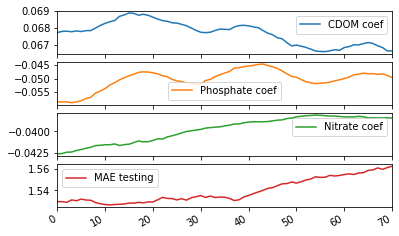

In [52]:
reg_result_table = pd.DataFrame(reg_result_table)
reg_result_table.plot(y=['CDOM coef', 'Phosphate coef', 'Nitrate coef', 'MAE testing'],
                     subplots=True)

In [21]:
reg_result_table

,Increment,CDOM coef,Phosphate coef,Nitrate coef,MAE testing
0,0.000000,0.06736,-0.059194,-0.042621,1.531054
1,0.041667,0.06736,-0.059194,-0.042621,1.531054
2,0.083333,0.06736,-0.059194,-0.042621,1.531054
3,0.125000,0.06736,-0.059194,-0.042621,1.531054
4,0.166667,0.06736,-0.059194,-0.042621,1.531054
...,...,...,...,...,...
92,3.833333,0.06736,-0.059194,-0.042621,1.531054
93,3.875000,0.06736,-0.059194,-0.042621,1.531054
94,3.916667,0.06736,-0.059194,-0.042621,1.531054
95,3.958333,0.06736,-0.059194,-0.042621,1.531054


ValueError: x and y must be the same size

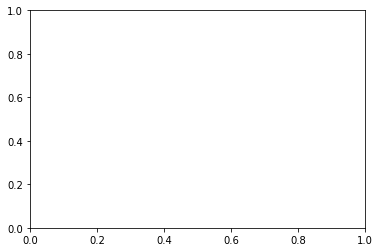

In [7]:
hour_shift = range(1,24*3,1)[10]
next_chl = []
for current_time in dataset['date']:
    time_shifted = current_time + datetime.timedelta(hours=hour_shift)
    x = dataset.loc[dataset['date']==time_shifted,'chlorophyll'].values
    if len(x) == 1:
        next_chl.append(x[0])
    else:
        next_chl.append(np.nan)
dataset['next_chl'] = next_chl

if True:
    dataset.plot(x=['cdom', 'phosphate', 'nitrate'], y=['next_chl'], subplots=True, kind='scatter')
    for x_var in ['cdom', 'phosphate', 'nitrate']:
        dataset.plot(x=x_var, y='next_chl', kind='scatter')
        
if False:
    X_vars = ['cdom', 'phosphate', 'nitrate']
    y_vars = ['next_chl']
    sub_dataset = dataset[X_vars+y_vars].dropna()
    X = np.array(sub_dataset[X_vars])
    y = np.array(sub_dataset[y_vars])
    reg = LinearRegression().fit(X,y)